# Advanced Xarray


*This material is adapted from the [Earth and Environmental Data Science](https://earth-env-data-science.github.io/intro.html), from Ryan Abernathey (Columbia University)*.


In this notebook, we cover some more advanced aspects of `Xarray`.

## Groupby

`Xarray` copies Pandas' very useful groupby functionality, enabling the "split / apply / combine" workflow on xarray DataArrays and Datasets. In the first part of the notebook, we will learn to use groupby by analyzing sea-surface temperature data.

In [5]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import xarray as xr

import geopandas as gpd

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
#plt.ion()  # To trigger the interactive inline mode

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns
import cmocean
import shutil
from PIL import Image  # To create gifs
%matplotlib inline

In [2]:
df = xr.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_bgc_GBR4_H2p0_B2p0_Chyd_Dnrt.ncml")



In [3]:
ds = df[['Gnet']]
ds


<xarray.Dataset>
Dimensions:    (time: 1178, j: 180, i: 600)
Coordinates:
    longitude  (j, i) float64 ...
    latitude   (j, i) float64 ...
  * time       (time) datetime64[ns] 2016-11-01T02:00:00 ... 2019-11-28T02:00:00
Dimensions without coordinates: j, i
Data variables:
    Gnet       (time, j, i) float32 ...
Attributes:
    Run_ID:       2.0
    hasVocab:     1
    title:        GBR4 BGC (Spectral) Transport
    paramhead:    GBR 4km resolution grid
    paramfile:    in.prm
    ems_version:  v1.0 rev(5997)
    Conventions:  CF-1.0

In [4]:
print(' model spatial extent:\n')
print(' - Longitudinal extent:',np.nanmin(ds['longitude']),np.nanmax(ds['longitude']))
print(' - Latitudinal extent:',np.nanmin(ds['latitude']),np.nanmax(ds['latitude']))


 model spatial extent:

 - Longitudinal extent: 142.168788 156.8856378
 - Latitudinal extent: -28.6960218 -7.0119082


In [5]:
# Removing non-finite values
ds.latitude.values = np.nan_to_num(ds.latitude.values)
ds.longitude.values = np.nan_to_num(ds.longitude.values)
# Check the arrays shapes
print(ds.longitude)

<xarray.DataArray 'longitude' (j: 180, i: 600)>
array([[142.168788 , 142.1804468, 142.19211  , ...,   0.       ,
          0.       ,   0.       ],
       [142.2013204, 142.2123752, 142.2236158, ...,   0.       ,
          0.       ,   0.       ],
       [142.2333969, 142.2441535, 142.25509  , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [147.8135068, 147.8142988, 147.8153794, ..., 156.8042355,
        156.8051407, 156.8061819],
       [147.8353694, 147.8363158, 147.8375886, ..., 156.84433  ,
        156.8451114, 156.8460513],
       [147.8566896, 147.8580363, 147.8596273, ..., 156.8843511,
        156.8849406, 156.8856378]])
Coordinates:
    longitude  (j, i) float64 142.2 142.2 142.2 142.2 ... 156.9 156.9 156.9
    latitude   (j, i) float64 -8.074 -8.107 -8.139 ... -28.52 -28.56 -28.59
Dimensions without coordinates: j, i
Attributes:
    standard_name:    longitude
    long_name:        Longitude
    units:            degrees_east
    coordinate_type:  long

Let's do some basic visualizations of the data, just to make sure it looks reasonable.

/usr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


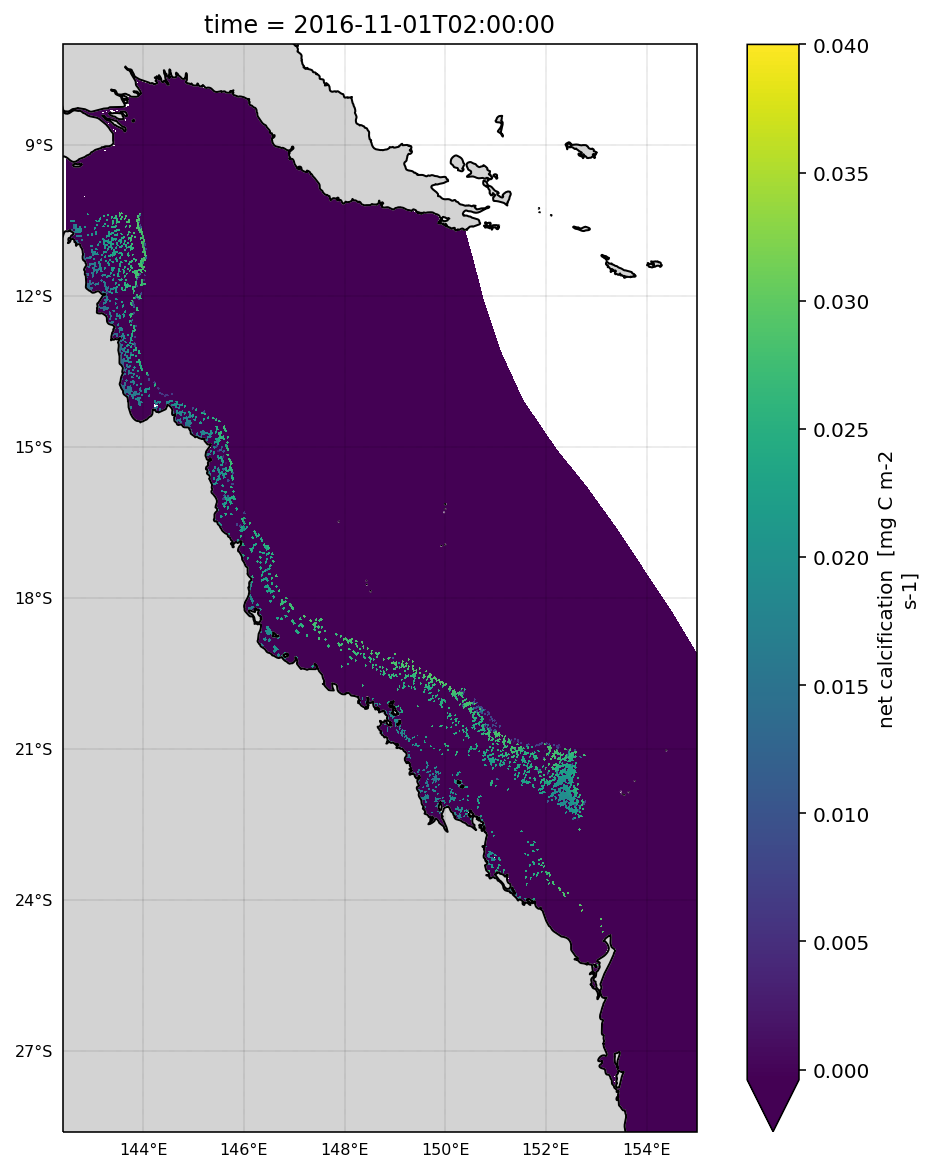

In [6]:
fig= plt.figure(figsize=(9,10), facecolor='w', edgecolor='k')

ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                                edgecolor='face', 
                                                facecolor='lightgray'))
ax.coastlines(linewidth=1)

# Plot lat/lon grid 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0.1, color='k', alpha=1, 
                      linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8} 

#Plotting map, and setting x,y limits
ax.set_extent([142.4, 155, -7, -28.6], ccrs.PlateCarree())



ds.Gnet[0].plot.pcolormesh(ax=ax,
                            x='longitude', y='latitude', 
                            vmin=-0.0004, vmax=0.04, 
                            cmap= 'viridis')


Note that xarray correctly parsed the time index, resulting in a Pandas datetime index on the time dimension.

In [4]:
gdf = gpd.read_file("GBR Features Shapefile/Great_Barrier_Reef_Features.shp")
gdf
# only extract data that relates to reefs 
reef = gdf['FEAT_NAME'] == "Reef"
reef = gdf[reef]


In [5]:
dots = pd.read_csv('Reef_Scatter.csv')


In [ ]:
# df_all = xr.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_bgc_GBR4_H2p0_B2p0_Chyd_Dnrt.ncml?longitude[0:1:179][0:1:599],latitude[0:1:179][0:1:599],time[0:1:1177],Gnet[0:1:1177][0:1:179][0:1:599]")
# df_all = df_all[['Gnet']]

# # fixing repeated time stamps
# # step 1
# df_all["time"] = df_all["time"].dt.floor("D")

# # step 2
# val,idx = np.unique(df_all.time, return_index=True)
# df_all = df_all.isel(time=idx)

# df_all = df_all.resample(time='Y').mean(dim='time')
# df_all

# # Removing non-finite values
# df_all.latitude.values = np.nan_to_num(df_all.latitude.values)
# df_all.longitude.values = np.nan_to_num(df_all.longitude.values)

In [ ]:
# df_all.to_netcdf('monthly-gnet.nc')

In [ ]:
df_all = xr.open_dataset('monthly-gnet.nc')

In [ ]:
gb = df_all.groupby('time.month')
ds_anom = gb - gb.mean(dim='time')
ds_anom

In [ ]:
print(' Gnet limits:\n')
print(' - Gnet min/max:',np.nanmin(ds_anom['Gnet']),np.nanmax(ds_anom['Gnet']))


In [ ]:
# imgs = []
# for time in range(10,37): 
# # for time in range(ds_anom['time'].shape[0]):

#     fig= plt.figure(figsize=(10,11), facecolor='w', edgecolor='k')

#     ax = plt.axes(projection=ccrs.PlateCarree())

#     ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', 
#                                                 edgecolor='face', 
#                                                 facecolor='lightgray'))
#     ax.coastlines(linewidth=1)

#     # Plot lat/lon grid 
#     gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                       linewidth=0.1, color='k', alpha=1, 
#                       linestyle='--')
#     gl.top_labels = False
#     gl.right_labels = False
#     gl.xformatter = LONGITUDE_FORMATTER
#     gl.yformatter = LATITUDE_FORMATTER
#     gl.xlabel_style = {'size': 8}
#     gl.ylabel_style = {'size': 8} 

#     #Setting x,y limits
#     ax.set_extent([142.4, 157, -7, -28.6], ccrs.PlateCarree())


#     #Plotting map

#     raster= ds_anom.Gnet[time].plot.pcolormesh(ax=ax,
#                                x='longitude', y='latitude', 
#                                vmin=-0.03, vmax=0.03,
#                                cmap= "seismic_r")





#     plt.savefig(f'images/Gnet_anom_{time:04}.png', dpi=200)
    
#     imgs.append(f"images/Gnet_anom_{time:04}.png")

    

In [1]:
imgs = []
for time in range(0,37):
    imgs.append(f"images/Gnet_anom_{time:04}.png")
imgs

['images/Gnet_anom_0000.png',
 'images/Gnet_anom_0001.png',
 'images/Gnet_anom_0002.png',
 'images/Gnet_anom_0003.png',
 'images/Gnet_anom_0004.png',
 'images/Gnet_anom_0005.png',
 'images/Gnet_anom_0006.png',
 'images/Gnet_anom_0007.png',
 'images/Gnet_anom_0008.png',
 'images/Gnet_anom_0009.png',
 'images/Gnet_anom_0010.png',
 'images/Gnet_anom_0011.png',
 'images/Gnet_anom_0012.png',
 'images/Gnet_anom_0013.png',
 'images/Gnet_anom_0014.png',
 'images/Gnet_anom_0015.png',
 'images/Gnet_anom_0016.png',
 'images/Gnet_anom_0017.png',
 'images/Gnet_anom_0018.png',
 'images/Gnet_anom_0019.png',
 'images/Gnet_anom_0020.png',
 'images/Gnet_anom_0021.png',
 'images/Gnet_anom_0022.png',
 'images/Gnet_anom_0023.png',
 'images/Gnet_anom_0024.png',
 'images/Gnet_anom_0025.png',
 'images/Gnet_anom_0026.png',
 'images/Gnet_anom_0027.png',
 'images/Gnet_anom_0028.png',
 'images/Gnet_anom_0029.png',
 'images/Gnet_anom_0030.png',
 'images/Gnet_anom_0031.png',
 'images/Gnet_anom_0032.png',
 'images/G

In [7]:
from PIL import Image
# Create the frames
frames = []
frames = []
for i in imgs:
    new_frame = Image.open(i)

# Save into a GIF file that loops forever
# frames[0].save('images/Gnet-anom.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=500, loop=0)


In [8]:
im = Image.open('images/Gnet-anom.gif')
im

FileNotFoundError: [Errno 2] No such file or directory: 'images/Gnet-anom.gif'